In [5]:
import numpy as np
import pandas as pd

In [6]:
gt = pd.read_csv("../dfs/gt_old.tsv", sep = '\t')
#gt = gt[gt.ignore_state == 0]
det = pd.read_csv("../dfs/res_df_ep0.tsv", sep = '\t')
#det = det[det.score >= 0]

det_labels = ["4w", '4w_ignore', '4w_remove']
gt_labels = ["CAR", "CAR_CIPV", "VAN_NLV", "TRUCK", "VAN", "CAR_NLV", 
             "BUS", "TRUCK_NLV", "BUS_CIPV", "TRUCK_CIPV", "BUS_NLV", 
             "VAN_CIPV", "TRAILER", "TOW_TRUCK", "RV", "CONSTRUCTION_VEHICLE"]

# Filter gt and det DataFrames based on labels


image_names = gt.name.unique()




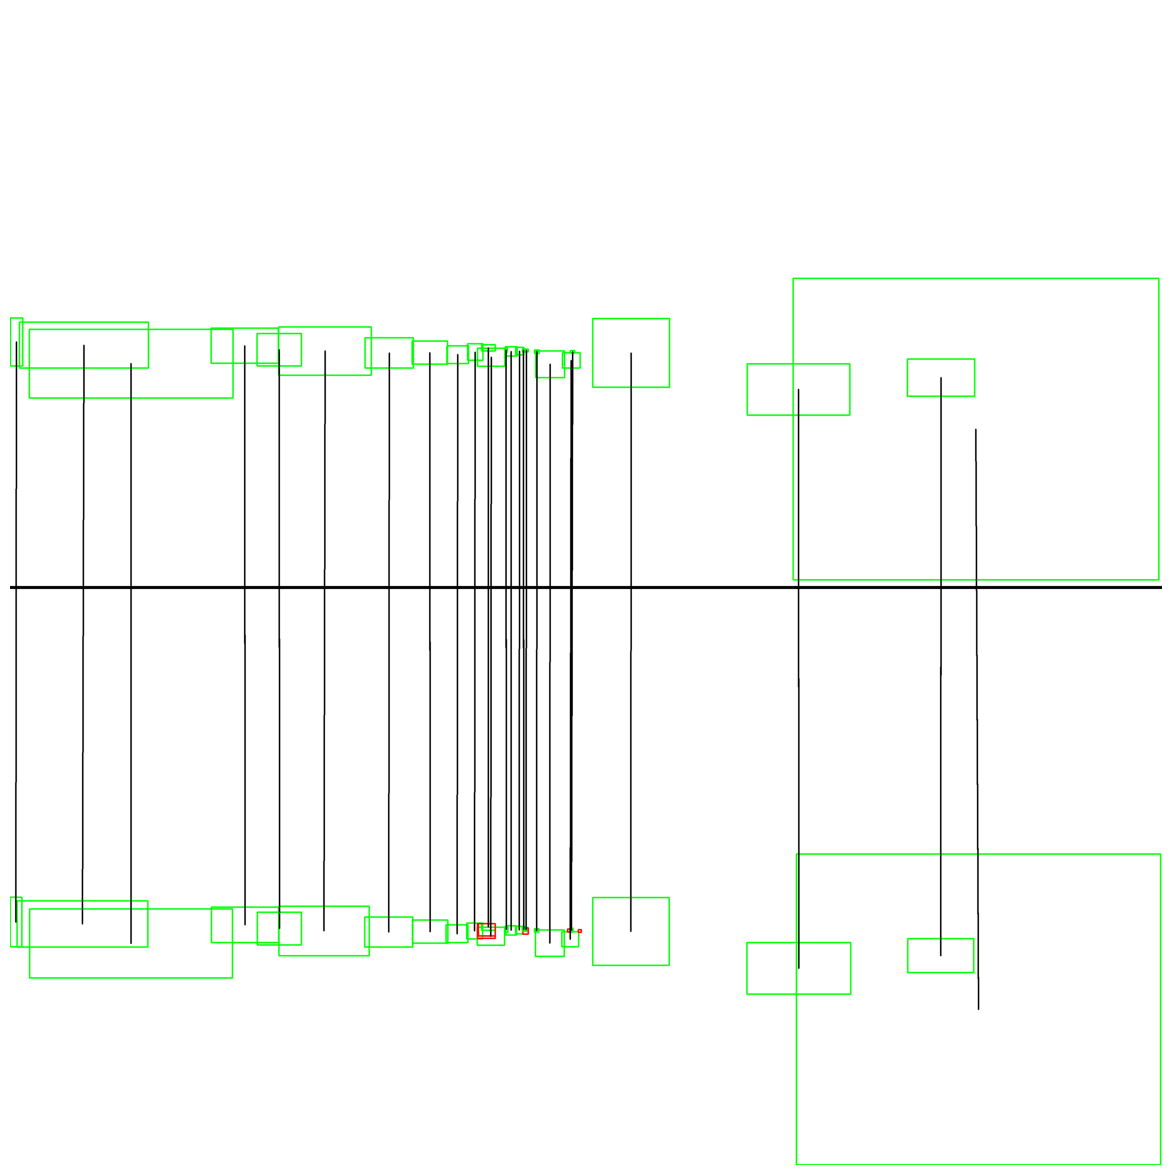

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import linear_sum_assignment
import cv2

def calculate_ious_matrix(gt_boxes, det_boxes):
    iou_matrix = np.zeros((len(gt_boxes), len(det_boxes)))

    for i, gt in enumerate(gt_boxes):
        for j, det in enumerate(det_boxes):
            xA = max(gt[0], det[0])
            yA = max(gt[1], det[1])
            xB = min(gt[0] + gt[2], det[0] + det[2])
            yB = min(gt[1] + gt[3], det[1] + det[3])
            
            interArea = max(0, xB - xA) * max(0, yB - yA)
            boxAArea = gt[2] * gt[3]
            boxBArea = det[2] * det[3]
            
            iou = interArea / float(boxAArea + boxBArea - interArea + 1e-9)
            iou_matrix[i, j] = iou

    return iou_matrix

def calculate_cost_matrix(iou_matrix, scores):
    cost_matrix = 1 - iou_matrix
    
    # Penalize low scores by adding a small negative value to the cost
    for j, score in enumerate(scores):
        cost_matrix[:, j]  = -score/100  # Smaller penalty for low scores

    # Set cost to a very high value (large number) for pairs with IoU < 0.5
    cost_matrix[iou_matrix < 0.5] = 10  
    return cost_matrix

def match(cost_matrix):
    row_ind, col_ind = linear_sum_assignment(cost_matrix)
    match_result = []
    
    for r, c in zip(row_ind, col_ind):
        if cost_matrix[r, c] < 0:
            match_result.append((r, c))
    
    return match_result

def add_match_column(gt_df, det_df, match_result):
    # Reset the index to ensure proper indexing after slicing
    gt_df = gt_df.reset_index(drop=True)
    det_df = det_df.reset_index(drop=True)
    
    gt_df['match'] = -1
    det_df['match'] = -1
    
    for gt_idx, det_idx in match_result:
        gt_df.at[gt_idx, 'match'] = det_idx
        det_df.at[det_idx, 'match'] = gt_idx
    
    return gt_df, det_df

def plot_image(gt_df, det_df, im_size=(3840, 1920)):
    # Create blank images for GT and DET
    gt_image = np.ones((im_size[1], im_size[0], 3), dtype=np.uint8) * 255
    det_image = np.ones((im_size[1], im_size[0], 3), dtype=np.uint8) * 255

    # Plot GT boxes
    for _, row in gt_df.iterrows():
        color = (0, 255, 0) if row['match'] != -1 else (0, 0, 255)
        cv2.rectangle(gt_image, 
                      (int(row['x_center'] - row['width'] / 2), int(row['y_center'] - row['height'] / 2)),
                      (int(row['x_center'] + row['width'] / 2), int(row['y_center'] + row['height'] / 2)), 
                      color, 3)

    # Plot DET boxes
    for _, row in det_df.iterrows():
        color = (0, 255, 0) if row['match'] != -1 else (255, 0, 0)
        cv2.rectangle(det_image, 
                      (int(row['x_center'] - row['width'] / 2), int(row['y_center'] - row['height'] / 2)),
                      (int(row['x_center'] + row['width'] / 2), int(row['y_center'] + row['height'] / 2)), 
                      color, 3)

    # Combine GT and DET images vertically with a separation line
    combined_image = np.vstack((gt_image, np.zeros((10, im_size[0], 3), dtype=np.uint8), det_image))

    # Draw lines connecting matched boxes
    for _, row in gt_df.iterrows():
        if row['match'] != -1:
            det_row = det_df.loc[row['match']]
            cv2.line(combined_image, 
                     (int(row['x_center']), int(row['y_center'])), 
                     (int(det_row['x_center']), int(det_row['y_center'] + im_size[1] + 10)), 
                     (0, 0, 0), 3)  # Black line with thicker width

    # Display using matplotlib
    plt.figure(figsize=(15, 15))
    plt.imshow(combined_image)
    plt.axis('off')
    plt.show()

for image_name in image_names:

    gt_filtered = gt[gt['label'].isin(gt_labels)]
    det_filtered = det[det['label'].isin(det_labels)]

    gt_filtered = gt_filtered[gt_filtered.name == image_name]
    det_filtered = det_filtered[det_filtered.name == image_name]

    gt_filtered = gt_filtered[gt_filtered.name == image_name]
    det_filtered = det_filtered[det_filtered.name == image_name]

    # Example usage
    gt_boxes = gt_filtered[['x_center', 'y_center', 'width', 'height']].values
    det_boxes = det_filtered[['x_center', 'y_center', 'width', 'height']].values
    det_scores = det_filtered['score'].values

    iou_matrix = calculate_ious_matrix(gt_boxes, det_boxes)

#print (iou_matrix)

    cost_matrix = -1*np.array(iou_matrix)#calculate_cost_matrix(iou_matrix, det_scores)
    match_result = match(cost_matrix)

    gt_filtered, det_filtered = add_match_column(gt_filtered, det_filtered, match_result)
plot_image(gt_filtered, det_filtered)




In [236]:
gt_filtered

,name,x_center,y_center,width,height,label,is_occluded,is_truncated,d3_separation,r_label,is_rider_on_2_wheels,occlusion_state_b2b,is_on_road_bondery,l_label,importance_state,ignore_state,match
0,1689521858933411.png,292.416656,1142.000000,364.500000,193.333250,CAR,0,0,0.0,NaN,0,3,0,NaN,0,1,14
1,1689521858933411.png,618.000000,1126.666748,333.333340,141.333370,CAR,0,0,0.0,NaN,0,3,0,NaN,0,1,2
2,1689521858933411.png,1550.666748,1069.333374,53.333374,44.000000,CAR,0,0,0.0,NaN,0,4,0,NaN,0,1,6
3,1689521858933411.png,1937.333252,1024.666748,42.666626,37.333374,CAR,0,0,0.0,NaN,0,4,0,NaN,0,1,3
4,1689521858933411.png,2009.333252,1059.333374,34.666626,40.000000,CAR,0,0,0.0,NaN,0,4,0,NaN,0,1,7
5,1689521858933411.png,1600.899629,1064.412616,27.639959,30.716725,CAR,0,0,0.0,NaN,0,4,0,NaN,0,1,-1
6,1689521858933411.png,1645.771909,1071.961642,68.929282,58.309715,CAR,0,0,0.0,NaN,0,4,0,NaN,0,1,5
7,1689521858933411.png,1758.208534,1059.727014,39.241918,33.840460,CAR,0,0,0.0,NaN,0,4,0,NaN,0,1,8
8,1689521858933411.png,1784.824792,1046.971764,26.957491,21.866143,CAR,0,0,0.0,NaN,0,4,0,NaN,0,1,10
9,1689521858933411.png,1703.781701,1059.206392,25.933789,23.428011,CAR,0,0,0.0,NaN,0,4,0,NaN,0,1,-1


In [4]:
det_filtered

,Unnamed: 0,name,label,score,coco_label,x_center,y_center,width,height,is_occluded,is_truncated,d3_separation,l_label,r_label,is_rider_on_2_wheels,box_correction,new_score
23973,173993,1684253882634349.png,4w,97,CAR,1762.550903,1115.204880,199.800537,158.461212,0,0,0,NaN,NaN,0,NaN,97
23974,173994,1684253882634349.png,4w,95,CAR,802.939056,1115.889374,177.874817,83.895935,0,0,0,NaN,NaN,0,NaN,95
23975,173995,1684253882634349.png,4w,95,CAR,1591.955322,1082.600433,75.624023,61.477661,0,0,0,NaN,NaN,0,NaN,95
23976,173996,1684253882634349.png,4w,94,CAR,946.900787,1103.471909,170.607361,92.993683,0,0,0,NaN,NaN,0,NaN,94
23978,173998,1684253882634349.png,4w,89,CAR,1885.913391,1056.015823,28.640015,22.197662,0,0,0,NaN,NaN,0,NaN,89
23981,174001,1684253882634349.png,4w,83,CAR,1853.889343,1052.562057,29.587769,27.259674,0,0,0,NaN,NaN,0,NaN,83
23983,174003,1684253882634349.png,4w,77,CAR,1049.387360,1097.316940,112.895691,93.142609,0,0,0,NaN,NaN,0,NaN,77
23984,174004,1684253882634349.png,4w_ignore,54,CAR,1902.870850,1048.463043,14.374756,17.836548,0,0,0,NaN,NaN,0,NaN,54
23985,174005,1684253882634349.png,4w_ignore,52,CAR,1484.512695,1062.109299,29.374268,27.177765,0,0,0,NaN,NaN,0,NaN,52
23986,174006,1684253882634349.png,4w_ignore,52,CAR,1532.190186,1056.027054,31.636719,30.731659,0,0,0,NaN,NaN,0,NaN,52
